## This is code for trying to figure out why the eval goes crazy

### Imports and preloading

In [1]:
# import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
import torch.optim as optim
import torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
path="../../input/final_split_training_augmented/train"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # You can test the normalization but if u apply remember to apply for testing
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

allDataSet = datasets.ImageFolder(root=path, transform=transform)
totalSize = len(allDataSet)
reductionRatio = 1
reducedSize = int(totalSize * reductionRatio)
indices = list(range(totalSize))
random.shuffle(indices)
reduced_indices = indices[:reducedSize]
reducedDataset = Subset(allDataSet, reduced_indices)

print(f"Reduced Train: {len(reducedDataset)}")
dataloader = DataLoader(reducedDataset, batch_size=32, shuffle=True, drop_last=True)


Reduced Train: 8025


In [3]:
path="../../input/final_split_training_augmented/eval"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

evalSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Reduced Train: {len(evalSet)}")
valLoader = DataLoader(evalSet, batch_size=32, shuffle=True)


Reduced Train: 579


In [4]:
from collections import Counter

# Get the list of all targets (i.e., class indices)
targets = [label for _, label in evalSet]

# Count each class
class_counts = Counter(targets)

# Map class indices to names
idx_to_class = {v: k for k, v in evalSet.class_to_idx.items()}

# Print class name and count
for class_idx, count in sorted(class_counts.items()):
    class_name = idx_to_class[class_idx]
    print(f"{class_name}: {count}")


angry: 142
happy: 150
relaxed: 148
sad: 139


In [5]:
# Number of classes in your dataset
num_classes = len(reducedDataset.dataset.classes) 
print(num_classes)

4


### Code Strucutre

In [6]:
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model = efficientnet_b5(weights="DEFAULT")

num_classes = len(reducedDataset.dataset.classes)
print("Number of classes:", num_classes)

# Freeze everything
for param in model.parameters():
    param.requires_grad = False

for name, param in model.named_parameters():
    if "features.6" in name or "features.7" in name:  # fine-tune last few blocks
        param.requires_grad = True


# Add SE block + classifier
channels = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Unflatten(1, (channels, 1, 1)),          # Reshape [B, C] → [B, C, 1, 1]
    SqueezeExcitationBlock(channels),
    nn.Flatten(),                               # Back to [B, C]
    nn.Dropout(p=0.4),
    nn.Linear(channels, num_classes)
)


optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

Number of classes: 4


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

### Training

In [7]:
epochs = 5
bestAcc = 0.0
patience = 3
triggerTimes = 0
train_losses = []
val_losses = []


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    acc = correct / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {epoch_loss:.4f} Accuracy: {acc:.4f}")
    train_losses.append(acc)

    model.eval()
    evalLoss = 0
    evalCorrect = 0
    evalTotal = 0
    
    with torch.no_grad():
        for images, labels in valLoader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            evalLoss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            evalCorrect += (predicted == labels).sum().item()
            evalTotal += labels.size(0)
        
    valLoss = evalLoss / evalTotal
    valAcc = evalCorrect / evalTotal
    val_losses.append(valAcc)
    print(f"Eval  Loss: {valLoss:.4f} | Accuracy: {valAcc:.4f}")

    if valAcc > bestAcc:
        bestAcc = valAcc
        trigger_times = 0
        torch.save(model.state_dict(), "../../models/unclean/SEClassifier.pth")
    else:
        trigger_times += 1
        print(f"No improvement. Trigger {trigger_times}/{patience}")

        if trigger_times >= patience:
            print("Early stopping triggered.")
            break


Epoch [1/5] Loss: 0.9173 Accuracy: 0.6539
Eval  Loss: 0.8805 | Accuracy: 0.6321
Epoch [2/5] Loss: 0.3181 Accuracy: 0.8854
Eval  Loss: 0.9696 | Accuracy: 0.5993
No improvement. Trigger 1/3
Epoch [3/5] Loss: 0.1217 Accuracy: 0.9626
Eval  Loss: 0.9669 | Accuracy: 0.6269
No improvement. Trigger 2/3
Epoch [4/5] Loss: 0.0787 Accuracy: 0.9740
Eval  Loss: 1.0276 | Accuracy: 0.6183
No improvement. Trigger 3/3
Early stopping triggered.


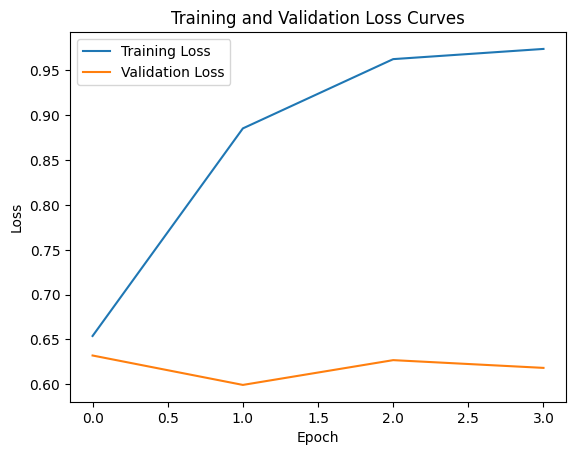

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()


### Testing

In [9]:
path="../../input/final_split_training_augmented/test"

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
])

allTestSet = datasets.ImageFolder(root=path, transform=transform)

print(f"Test set: {len(allTestSet)}")
dataloader = DataLoader(allTestSet, batch_size=32, shuffle=True)


Test set: 572


In [10]:
# Number of classes in your dataset
num_classes = len(dataloader.dataset.classes) 
print(num_classes)

4


In [11]:
from torchvision.models import efficientnet_b5
import torch.nn as nn
import torch

# Rebuild model structure with SqueezeExcitationBlock
class SqueezeExcitationBlock(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(SqueezeExcitationBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.interaction = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.interaction(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Load EfficientNet structure
model = efficientnet_b5(weights=None)

# Match the classifier structure from training
channels = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Unflatten(1, (channels, 1, 1)),           # restore shape to [B, C, 1, 1]
    SqueezeExcitationBlock(channels),
    nn.Flatten(),                                # back to [B, C]
    nn.Dropout(p=0.4),
    nn.Linear(channels, num_classes)
)

# Load weights
model.load_state_dict(torch.load("../../models/unclean/SEClassifier.pth"))
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [12]:
# Move model to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

target_names = allTestSet.classes
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.8024
Classification Report:
              precision    recall  f1-score   support

       angry       0.90      0.66      0.77       140
       happy       0.82      0.86      0.84       148
     relaxed       0.72      0.80      0.76       146
         sad       0.80      0.88      0.84       138

    accuracy                           0.80       572
   macro avg       0.81      0.80      0.80       572
weighted avg       0.81      0.80      0.80       572

Confusion Matrix:
[[ 93  24  18   5]
 [  7 128  13   0]
 [  2   2 117  25]
 [  1   2  14 121]]
